In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lag
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.early_stopping as es
import piml_library.plotting as plotting
from piml_library.lnn import (
    LagrangianNN, 
    compute_loss, 
    train_step, 
    create_trajectory,
    create_trajectory_for_hnn
)
import dataset_generator as dg

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lag.coordinate(state)
    v = lag.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
# --- ハイパーパラメータ ---
q_dim = 1      
hidden_dim = 300
learning_rate = 1e-3
num_epochs = 10000
key = jax.random.PRNGKey(8)
optimizer = optax.adamw(learning_rate, weight_decay=1e-4)
es = es.EarlyStopping(patience=100, verbose=True, path='best_lnn_params.pkl', mode='min', save_best_on_disk=False)
check_interval = 10
#batch_size = 256 

#trajectory
num_trajectories = 100
N_points_per_traj = 30 
t_end = 3.0         
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)
split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)


--- 学習用・テスト用データセットの生成開始 ---
Generating 100 trajectories...
--- データセット生成完了 ---
Total Train Points: 1500
Total Test Points:  1500


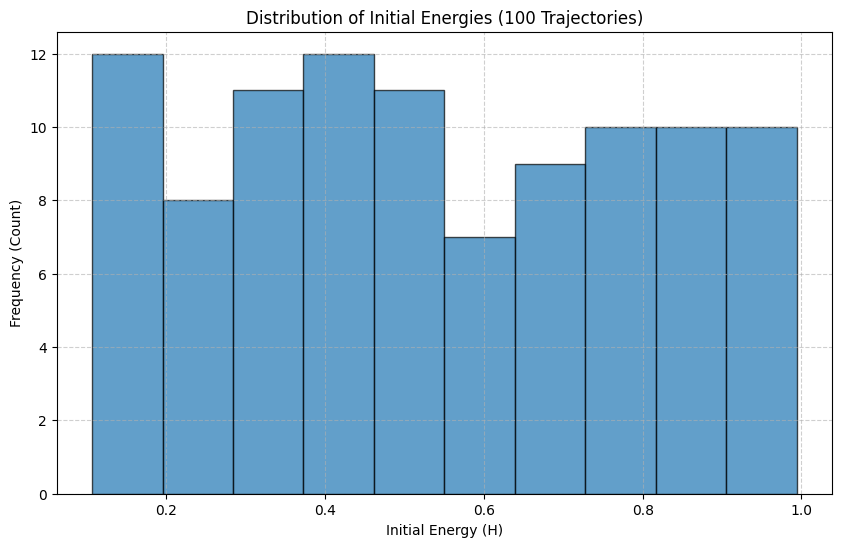

In [5]:
# --- モジュールの関数を呼び出してデータを生成 ---
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states_lnn"]
train_t, train_q, train_v = train_states
train_targets = data_dict["train_targets_lnn"]
test_dataset_states = data_dict["test_dataset_states_lnn"]
test_dataset_targets = data_dict["test_dataset_targets_lnn"]
initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

# --- エネルギー分布の可視化 ---
energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [6]:

'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
lnn_model = LagrangianNN(hidden_dim=hidden_dim, out_dim=q_dim)
model_apply_fn = lnn_model.apply  # jitで使用できるようにするためapplyというメソッドを変数に割り当てる。

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_v = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_v)

params = lnn_model.init(init_key, dummy_state)['params'] #構造を決定
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリ状態

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

train_loss_history = []
test_loss_history = []
test_steps_history = []

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    '''
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    t_batch = train_t[indices]
    q_batch = train_q[indices]
    v_batch = train_v[indices]
    
    batch_states = (t_batch, q_batch, v_batch)
    batch_true_accel = train_targets[indices]
    '''
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        train_states,
        train_targets
    )
    
    train_loss_history.append(float(train_loss))
    
    if epoch % check_interval == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_targets
        )
        
        test_loss_history.append(float(test_loss))
        test_steps_history.append(epoch)
        
        if epoch % 100 == 0:
             print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        es(test_loss, params)
        if es.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

print("学習完了。")
final_params = es.best_params

# Final Test Loss
final_test_loss = compute_loss(final_params, model_apply_fn, test_dataset_states, test_dataset_targets)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 13.927471, Test Loss: 1.020998
Validation metric set to 1.020998.  Saving model ...
Validation metric improved from 1.020998 to 0.705334.  Saving model ...
Validation metric improved from 0.705334 to 0.246243.  Saving model ...
Validation metric improved from 0.246243 to 0.215664.  Saving model ...
Validation metric improved from 0.215664 to 0.192817.  Saving model ...
Validation metric improved from 0.192817 to 0.176314.  Saving model ...
Validation metric improved from 0.176314 to 0.162938.  Saving model ...
Validation metric improved from 0.162938 to 0.137067.  Saving model ...
Validation metric improved from 0.137067 to 0.106197.  Saving model ...
Validation metric improved from 0.106197 to 0.081540.  Saving model ...
Epoch 100, Train Loss: 0.063904, Test Loss: 0.056923
Validation metric improved from 0.081540 to 0.056923.  Saving model ...
Validation metric improved from 0.056923 to 0.036146.  Saving model ...
Validation metric im

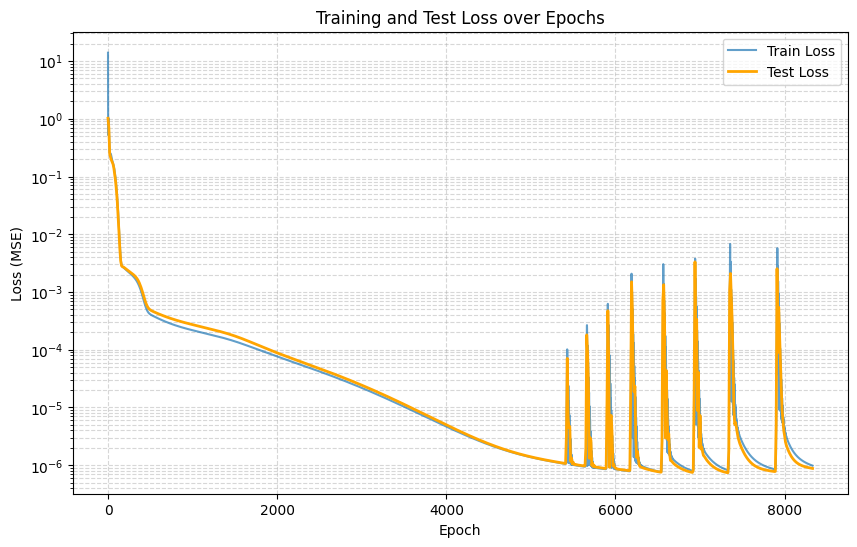

In [7]:
# --- Lossの可視化 ---
plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_steps_history, test_loss_history, label='Test Loss', linewidth=2, color='orange')

plt.yscale('log')  # 縦軸を対数表示にする
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [8]:
'''
generate trajectory
'''
LNN_fn = lambda s: model_apply_fn({'params': final_params}, s) 
HNN_from_LNN_fn = ham.lagrangian_to_hamiltonian(LNN_fn) 

lag_to_ham_state_fn_true = ham.lagrangian_state_to_hamiltonian_state(L_analytical)
ham_to_lag_state_fn_true = ham.hamiltonian_state_to_lagrangian_state(H_analytical)
lag_to_ham_state_fn_learned = ham.lagrangian_state_to_hamiltonian_state(LNN_fn)
ham_to_lag_state_fn_learned = ham.hamiltonian_state_to_lagrangian_state(HNN_from_LNN_fn)

solver_learned_lnn = create_trajectory(model_apply_fn, final_params)
solver_learned_hnn_from_lnn = create_trajectory_for_hnn(HNN_from_LNN_fn)

# Initial state
initial_states_ham_list = [
    (0.0, jnp.array([jnp.sqrt(0.2*(i+1))]), jnp.array([0.0]))  #H=[0.1, 1.0]の等間隔10点を初期値とする
    for i in range(10)
]
initial_states_lag_list = [
    (0.0, jnp.array([jnp.sqrt(0.2*(i+1))]), jnp.array([0.0]))  #H=[0.1, 1.0]の等間隔10点を初期値とする
    for i in range(10)
]

results_all = []
t_eval = jnp.linspace(0.0, 25.0, 2500)

#軌道生成のループ
for i, initial_state_lag in enumerate(initial_states_lag_list):
    #true
    ds_true = lag.state_derivative(L_analytical)
    solver_true = util.ode_solver(ds_true)
    lag_states_true = solver_true(initial_state_lag, t_eval)
    ham_states_true = jax.vmap(lag_to_ham_state_fn_true)(lag_states_true)

    #LNN
    lag_states_learned_lnn = solver_learned_lnn(initial_state_lag, t_eval) 
    ham_states_learned_lnn = jax.vmap(lag_to_ham_state_fn_true)(lag_states_learned_lnn)

    #HNN from LNN
    p_learned_init_fn = ham.lagrangian_state_to_hamiltonian_state(LNN_fn)
    initial_state_hnn_learned = p_learned_init_fn(initial_state_lag)
    ham_states_raw_trajectory = solver_learned_hnn_from_lnn(initial_state_hnn_learned, t_eval)
    lag_states_learned_hnn_from_lnn = jax.vmap(ham_to_lag_state_fn_learned)(ham_states_raw_trajectory) 
    ham_states_learned_hnn_from_lnn = jax.vmap(lag_to_ham_state_fn_true)(lag_states_learned_hnn_from_lnn)

    res = {
        "id": i,
        "initial_state": initial_state_lag,
        
        # Trueの結果 (ham_states, lag_states)
        "true": (ham_states_true, lag_states_true),
        
        # LNNの結果
        "lnn": (ham_states_learned_lnn, lag_states_learned_lnn),
        
        # LNN from HNNの結果
        "hnn_from_lnn": (ham_states_learned_hnn_from_lnn, lag_states_learned_hnn_from_lnn)
    }
    results_all.append(res)

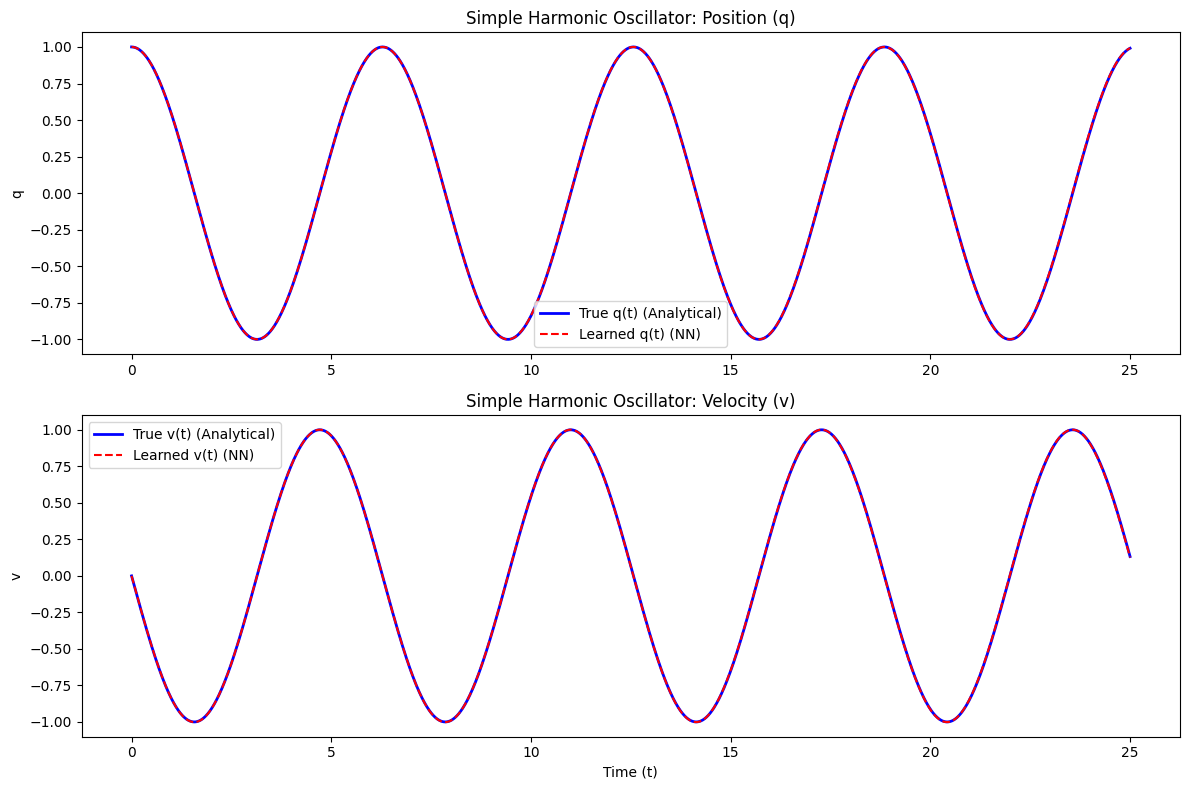

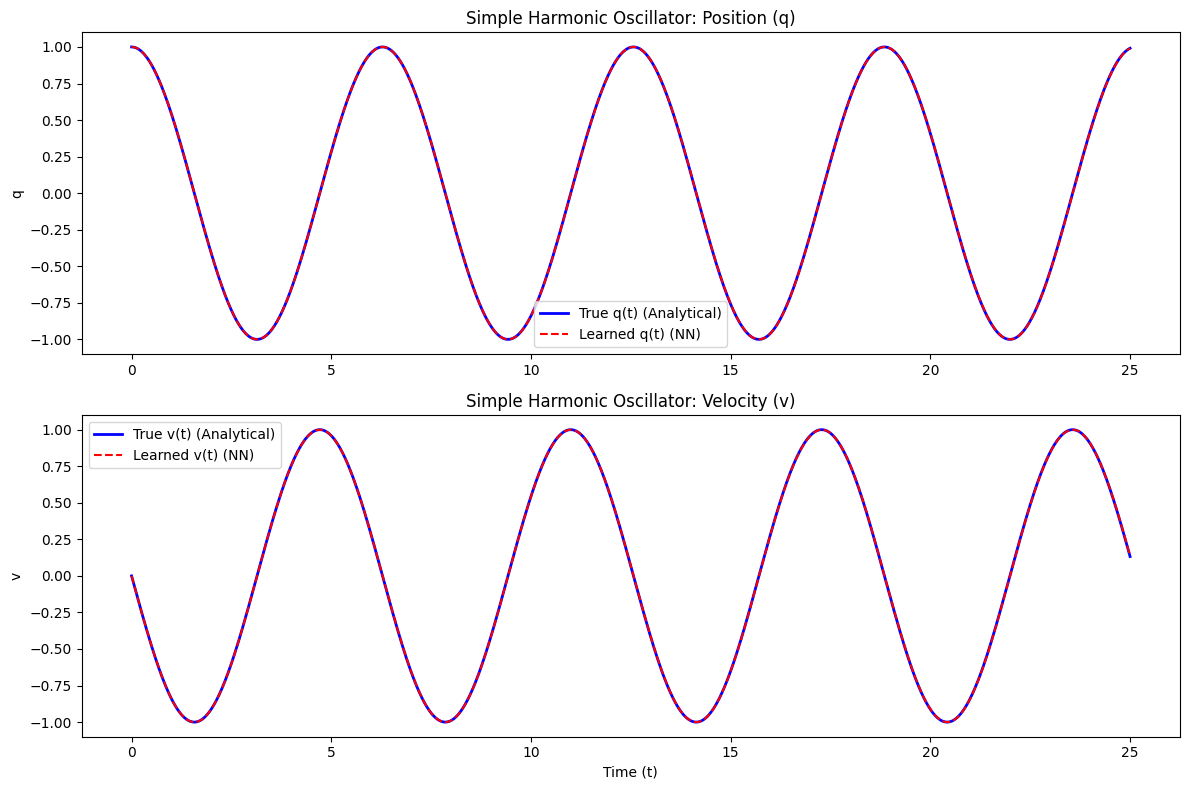

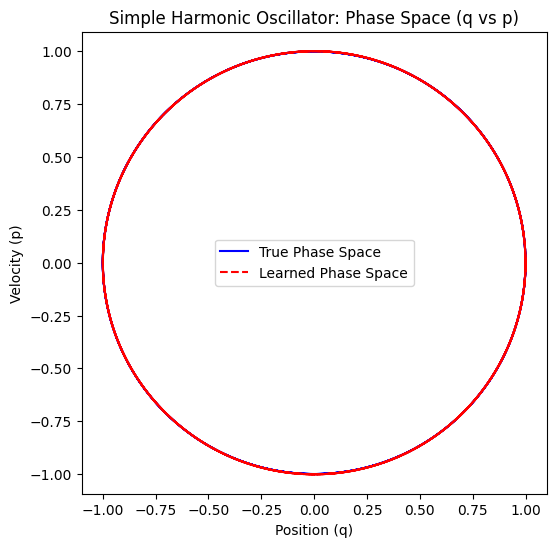

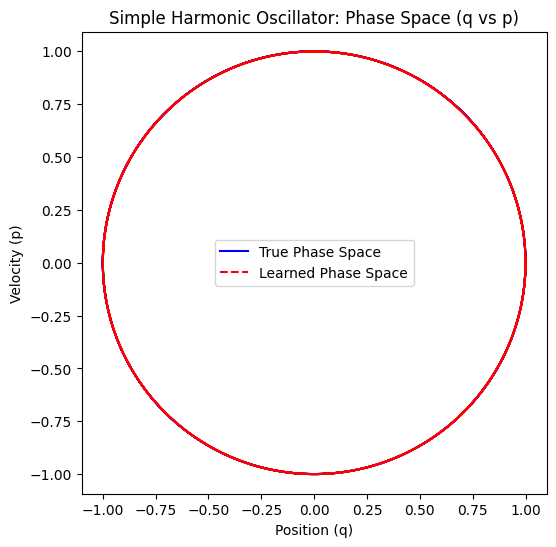

In [9]:
''' 
plot result
'''
# 図示したいデータのインデックスを指定
target_id = 4
res = results_all[target_id]

# True
ham_states_true, lag_states_true = res["true"]
t_true, q_true, p_true = ham_states_true
v_true = lag_states_true[2]

# LNN
ham_states_learned_lnn, lag_states_learned_lnn = res["lnn"]
t_learned_lnn, q_learned_lnn, p_learned_lnn = ham_states_learned_lnn
v_learned_lnn = lag_states_learned_lnn[2]

# HNN from LNN
ham_states_learned_hnn_from_lnn, lag_states_learned_hnn_from_lnn = res["hnn_from_lnn"]
t_learned_hnn_from_lnn, q_learned_hnn_from_lnn, p_learned_hnn_from_lnn = ham_states_learned_hnn_from_lnn
v_learned_hnn_from_lnn = lag_states_learned_hnn_from_lnn[2]

title_prefix="Simple Harmonic Oscillator:"

plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned_lnn, q_learned_lnn, v_learned_lnn,
    title_prefix
)

plotting.plot_trajectory_comparison(
    t_true, q_true, p_true, 
    t_learned_hnn_from_lnn, q_learned_hnn_from_lnn, p_learned_hnn_from_lnn,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned_lnn, p_learned_lnn,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned_hnn_from_lnn, p_learned_hnn_from_lnn,
    title_prefix
)


In [10]:
# データを保存
t_true_list, q_true_list, p_true_list, v_true_list = [], [], [], []
t_hnn_list, q_hnn_list, p_hnn_list, v_hnn_list = [], [], [], []
t_lnn_list, q_lnn_list, p_lnn_list, v_lnn_list = [], [], [], []

# results_all から各軌道データを抽出してリストに追加
for res in results_all:

    ham_true, lag_true = res["true"]
    t_true_list.append(ham_true[0])
    q_true_list.append(ham_true[1])
    p_true_list.append(ham_true[2])
    v_true_list.append(lag_true[2])  
    
    ham_hnn, lag_hnn = res["lnn"]
    t_lnn_list.append(ham_hnn[0])
    q_lnn_list.append(ham_hnn[1])
    p_lnn_list.append(ham_hnn[2])
    v_lnn_list.append(lag_hnn[2])
    
    ham_lnn, lag_lnn = res["hnn_from_lnn"]
    t_hnn_list.append(ham_lnn[0])
    q_hnn_list.append(ham_lnn[1])
    p_hnn_list.append(ham_lnn[2])
    v_hnn_list.append(lag_lnn[2])

np.savez(
    "results_H1D_LNN.npz", 
    
    # True
    t_true_lnn=np.array(t_true_list),
    q_true_lnn=np.array(q_true_list),
    v_true_lnn=np.array(v_true_list),
    p_true_lnn=np.array(p_true_list),
    
    # LNN
    t_learned_lnn=np.array(t_lnn_list),
    q_learned_lnn=np.array(q_lnn_list),
    v_learned_lnn=np.array(v_lnn_list),
    p_learned_lnn=np.array(p_lnn_list),
    
    # HNN from LNN
    t_learned_hnn_from_lnn=np.array(t_hnn_list),
    q_learned_hnn_from_lnn=np.array(q_hnn_list),
    v_learned_hnn_from_lnn=np.array(v_hnn_list),
    p_learned_hnn_from_lnn=np.array(p_hnn_list),
)